In [ ]:
%reset -f

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### **Importing Required Libraries**

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow import keras
import tqdm
import cv2

from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers
import seaborn as sns
import gzip

from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.client import device_lib
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

#### **Loading Training/Validation Dataset**

In [ ]:
train_path='/content/drive/MyDrive/seg_train/'

In [ ]:
os.listdir(train_path)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [ ]:
classes=os.listdir(train_path)

In [ ]:
length={}
for n1 in classes:
    l=len(os.listdir(train_path+'/'+n1))
    length[n1]=l
length

{'buildings': 2191,
 'forest': 2271,
 'glacier': 2404,
 'mountain': 2512,
 'sea': 2274,
 'street': 2382}

In [ ]:
sumi=0
for e1 in length:
    sumi+=length[e1]
sumi

14034

In [ ]:
x=[]
y=[]
num_samples_per_class = 1500
sampled_count_per_class = {labels: 0 for labels in classes}
for labels in classes:
    pth=os.path.join(train_path,labels)
    for img in tqdm.tqdm(os.listdir(pth)):
      if sampled_count_per_class[labels] >= num_samples_per_class:
            break
      else:
          pic=cv2.imread(os.path.join(pth,img))
          x.append(pic)
          y.append(classes.index(labels))
      sampled_count_per_class[labels]+=1

 63%|██████▎   | 1500/2382 [00:59<00:35, 25.09it/s] 


#### **Pre-Processing of Dataset**

#### Resizing to 128x128

In [ ]:
for i in range(len(x)):
    img = np.array(x[i])
    x[i] = cv2.resize(img,(128,128))

In [ ]:
x = np.array(x)
y = np.array(y)

In [ ]:
np.save('trainX',x)
np.save('trainY',y)

In [ ]:
x.shape

(9000, 128, 128, 3)

In [ ]:
y.shape

(9000,)

In [ ]:
import numpy as np
x = np.load("/content/trainX.npy")
y = np.load("/content/trainY.npy")

#### Splitting into training and validation sets

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
X_train= X_train / 255.0

In [ ]:
X_valid = X_valid / 255.0

#### **Deep CNN Model Initialization**

In [ ]:
#new model config acc to what sir told today, you may make more changes to this
# it gave 0.82583 val accuracy without overfitting, as can be seen below in history
esp = 20
callback=[
      tf.keras.callbacks.ModelCheckpoint(filepath="/content/drive/MyDrive/CNN/weights/best_model.h5", monitor='val_loss',save_best_only=True,verbose=1,save_weights_only=False,mode='auto'),
      tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=esp, restore_best_weights=True),
      tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5,min_lr=1e-4)
    ]
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])
#also save weights of model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2  (None, 62, 62, 16)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 32)        4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 58, 58, 32)        9248      
                                                                 
 dropout (Dropout)           (None, 58, 58, 32)        0         
                                                        

#### **Model Training & Validation**

In [ ]:
# training of new config model with 0.82583 val accuracy
history = model.fit(X_train,y_train, epochs=150,batch_size=32, validation_data=(X_valid,y_valid), callbacks=callback)

Epoch 1/150
224/225 [============================>.] - ETA: 0s - loss: 1.3142 - accuracy: 0.4177
Epoch 1: val_accuracy improved from -inf to 0.49556, saving model to /content/drive/MyDrive/CNN/weights/best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


225/225 [==============================] - 19s 44ms/step - loss: 1.3128 - accuracy: 0.4183 - val_loss: 1.3129 - val_accuracy: 0.4956 - lr: 0.0010
Epoch 2/150
223/225 [============================>.] - ETA: 0s - loss: 1.0797 - accuracy: 0.5265
Epoch 2: val_accuracy improved from 0.49556 to 0.51833, saving model to /content/drive/MyDrive/CNN/weights/best_model.h5
225/225 [==============================] - 6s 29ms/step - loss: 1.0782 - accuracy: 0.5272 - val_loss: 1.2472 - val_accuracy: 0.5183 - lr: 0.0010
Epoch 3/150
223/225 [============================>.] - ETA: 0s - loss: 0.9877 - accuracy: 0.5600
Epoch 3: val_accuracy improved from 0.51833 to 0.60222, saving model to /content/drive/MyDrive/CNN/weights/best_model.h5
225/225 [==============================] - 6s 28ms/step - loss: 0.9860 - accuracy: 0.5604 - val_loss: 1.1541 - val_accuracy: 0.6022 - lr: 0.0010
Epoch 4/150
224/225 [============================>.] - ETA: 0s - loss: 0.9321 - accuracy: 0.6042
Epoch 4: val_accuracy improved 

#### **Training & Validation Loss/Accuracy Curves**

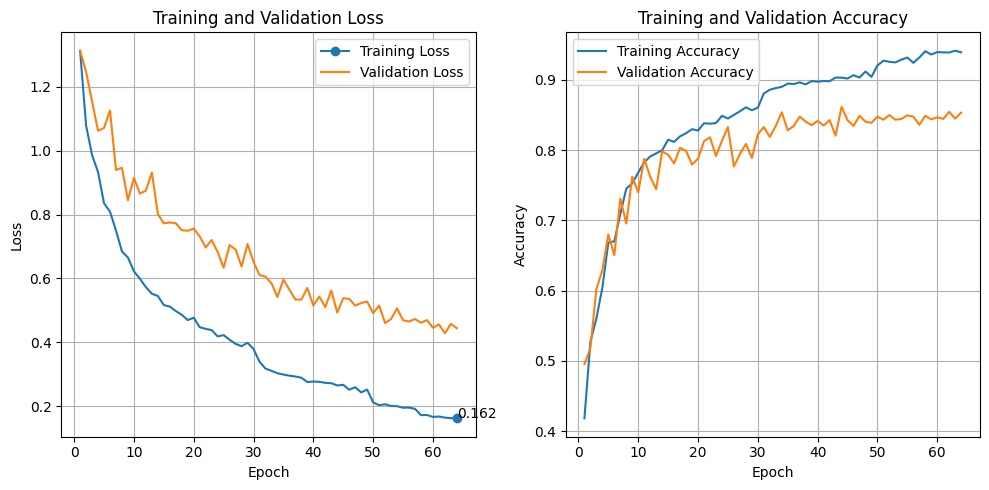

In [ ]:
import matplotlib.pyplot as plt
ep = [i for i in range(1,len(history.history['loss'])+1)]
curves = [history.history[i] for i in ['loss','val_loss','accuracy','val_accuracy']]
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(ep,curves[0],'o',ls='-',label='Training Loss',markevery=[-1])
plt.plot(ep,curves[1], label='Validation Loss')
l1 = (ep[-1],curves[0][-1])
plt.annotate(f"{l1[1]:.3f}",xy=l1)
l2 = (ep[-1],curves[1][-1])
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(ep,curves[2], label='Training Accuracy')
plt.plot(ep,curves[3], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()
# plots for new config model2

#### Saving Model

In [ ]:
bmodel = keras.models.load_model("/content/drive/MyDrive/CNN/weights/best_model_0.86167.h5")

#### **Loading Test Dataset**

In [ ]:
test_path='/content/drive/MyDrive/seg_test/seg_test/'

In [ ]:
classes = ['buildings','forest','glacier','mountain','sea','street']

In [ ]:
lentest={}
for n1 in classes:
    l=len(os.listdir(test_path+'/'+n1))
    lentest[n1]=l
lentest

{'buildings': 437,
 'forest': 474,
 'glacier': 553,
 'mountain': 525,
 'sea': 510,
 'street': 501}

In [ ]:
testimg=0
for e1 in lentest:
    testimg+=lentest[e1]
testimg

3000

In [ ]:
xtest=[]
ytest=[]
for label in classes:
    pth=os.path.join(test_path,label)
    for img in tqdm.tqdm(os.listdir(pth)):
          pic=cv2.imread(os.path.join(pth,img))
          xtest.append(pic)
          ytest.append(classes.index(label))

100%|██████████| 501/501 [00:04<00:00, 120.30it/s]


#### **Pre-Processing on Test Dataset**

In [ ]:
for i in range(len(xtest)):
    img = np.array(xtest[i])
    xtest[i] = cv2.resize(img,(128,128))

In [ ]:
xtest = np.array(xtest)/255
ytest = np.array(ytest)
np.save('testX',xtest)
np.save('testY',ytest)

In [ ]:
import numpy as np
xtest = np.load("/content/testX.npy")
ytest = np.load("/content/testY.npy")

In [ ]:
ytest

array([0, 0, 0, ..., 5, 5, 5])

#### **Results of Model Testing**

In [ ]:
ypred = bmodel.predict(xtest,batch_size=32)

94/94 [==============================] - 1s 7ms/step


In [ ]:
ypredi = np.argmax(ypred,axis=1)
ypredi

array([0, 0, 0, ..., 5, 5, 5])

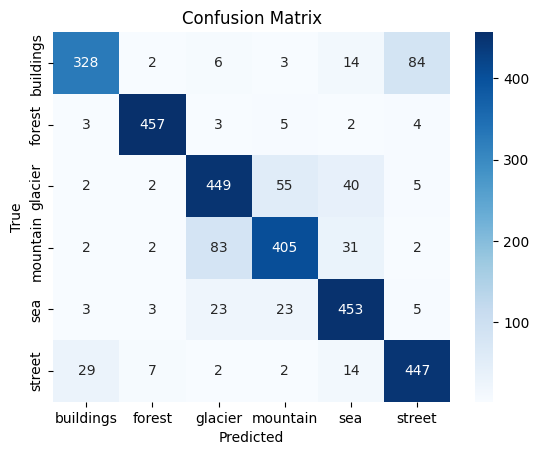

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,f1_score
cm = confusion_matrix(ytest,ypredi)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
acc = accuracy_score(ytest,ypredi)
print(f"Accuracy = {acc*100:.2f}%")

Accuracy = 84.63%


In [ ]:
f1 = f1_score(ytest,ypredi,average='macro')
print(f"F1-Score = {f1*100:.2f}%")

F1-Score = 84.73%


In [ ]:
rep = classification_report(ytest,ypredi,target_names=classes)
print(rep)

              precision    recall  f1-score   support

   buildings       0.89      0.75      0.82       437
      forest       0.97      0.96      0.97       474
     glacier       0.79      0.81      0.80       553
    mountain       0.82      0.77      0.80       525
         sea       0.82      0.89      0.85       510
      street       0.82      0.89      0.85       501

    accuracy                           0.85      3000
   macro avg       0.85      0.85      0.85      3000
weighted avg       0.85      0.85      0.85      3000

